In [1]:

from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import math
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import app, flags
from easydict import EasyDict
from tensorflow.keras import Model
from tensorflow.keras.layers import AveragePooling2D, Dense, Flatten, Conv2D, MaxPool2D

from tensorflow.keras import layers
from tqdm import tqdm
import matplotlib.pyplot as plt

from cleverhans.future.tf2.attacks import projected_gradient_descent, fast_gradient_method

#tf.compat.v1.enable_eager_execution()
tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = [x_train.reshape(60000, 784).astype('float32') / 255]
x_test = x_test.reshape(10000, 784).astype('float32') / 255

# Weights

In [3]:
weights = {
    # 5x5 conv, 1 input, 6 outputs
    'weights_conv_1': tf.Variable(tf.random.normal([5, 5, 1, 6])),
    # 5x5 conv, 6 inputs, 16 outputs
    'weights_conv_2': tf.Variable(tf.random.normal([5, 5, 6, 16])),
    #5x5 conv as in paper, 16 inputs, 120 outputs
    'weights_conv_3': tf.Variable(tf.random.normal([5, 5, 16, 120])),
    # fully connected, 5*5*16 inputs, 120 outputs
    'weights_dense_1': tf.Variable(tf.random.normal([5*5*16, 120])),
    # fully connected, 120 inputs, 84 outputs
    'weights_dense_2': tf.Variable(tf.random.normal([120, 84])),
    # 84 inputs, 10 outputs (class prediction)
    'weights_dense_3': tf.Variable(tf.random.normal([84, 10])),
}

biases = {
    #output depth
    'bias_conv_1': tf.Variable(tf.random.normal([6])),
    'bias_conv_2': tf.Variable(tf.random.normal([16])),
    'bias_dense_1': tf.Variable(tf.random.normal([120])),
    'bias_dense_2': tf.Variable(tf.random.normal([84])),
    'bias_dense_3': tf.Variable(tf.random.normal([10])),
}



# Wrappers

In [4]:
#conv2D with bias and relu activation

class CustomConvLayer(layers.Layer):

    def __init__(self, weights, biases, strides, padding='SAME'):
        
        super(CustomConvLayer, self).__init__()
        self.w = weights
        self.b = biases
        self.s = strides
        self.p = padding

        
    def call(self, inputs):
        x = tf.nn.conv2d(inputs, self.w, strides=[1, self.s, self.s, 1], padding=self.p)
        x = tf.nn.bias_add(x, self.b)
        return tf.nn.tanh(x)
        

#Average Pooling Layer
class CustomPoolLayer(layers.Layer):
    
    def __init__(self, k=2, padding='VALID'):
        super(CustomPoolLayer, self).__init__()
        self.k = k
        self.p = padding
    
    def call(self, inputs):
        return tf.nn.avg_pool2d(inputs, ksize=[1, self.k, self.k,1], strides=[1, self.k, self.k, 1], padding=self.p)

    
#Dense Layer with Bias
class CustomDenseLayer(layers.Layer):
    
    def __init__(self, weights, bias, activation = 'tanh'):
        super(CustomDenseLayer, self).__init__()
        self.w = weights
        self.b = bias
        self.a = activation
        
    def call(self, inputs):
        #print(self.w)
        #print(inputs)
        x = tf.matmul(inputs, self.w)
        #print(x)
        x = tf.nn.bias_add(x, self.b)
        if self.a == 'tanh':
            return tf.nn.tanh(x)
        if self.a == 'softmax':
            return tf.nn.softmax(x)


# Create Model

In [69]:
class CustomConvModel(tf.keras.Model):
    def __init__(self):
        super(CustomConvModel, self).__init__()
        self.conv1 = CustomConvLayer(weights['weights_conv_1'], biases['bias_conv_1'], 1, 'SAME')#'VALID')
        self.maxpool1 = CustomPoolLayer(k=2, padding='SAME')
        self.conv2 = CustomConvLayer(weights['weights_conv_2'], biases['bias_conv_2'], 1, 'VALID')
        self.maxpool2 = CustomPoolLayer(k=2, padding='VALID')
        self.conv3 = CustomConvLayer(weights['weights_conv_3'], biases['bias_dense_1'], 1, 'VALID')
        #self.dense1 = CustomDenseLayer(weights['weights_dense_1'], biases['bias_dense_1'], 'tanh')
        self.dense2 = CustomDenseLayer(weights['weights_dense_2'], biases['bias_dense_2'], 'tanh')
        self.dense3 = CustomDenseLayer(weights['weights_dense_3'], biases['bias_dense_3'], 'softmax')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()
        
    def call(self, inputs):
        x = tf.reshape(inputs, shape=[-1, 28, 28, 1])
        print(x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        print(x.shape)
        x = self.maxpool1(x)
        print(x.shape)
        x = self.conv2(x)
        x = self.bn2(x)
        print(x.shape)
        x = self.maxpool2(x)
        #print('yo',x.shape)
        #x = layers.Flatten()(x)
        print(x.shape)
        x = self.conv3(x)
        print(x.shape)
        x = layers.Flatten()(x)
        print(x.shape)
        x = self.bn3(x)
        x =  self.dense2(x)
        print(x.shape)
        x =  self.dense3(x)
        print(x.shape)
        return x
        

In [70]:
model = CustomConvModel()

In [71]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              experimental_run_tf_function=False
             )

In [72]:
model.fit(x=x_train,
          y=y_train,
          batch_size=64,
          epochs=10,
          validation_data=(x_test, y_test),
         )

(None, 28, 28, 1)
(None, 28, 28, 6)
(None, 14, 14, 6)
(None, 10, 10, 16)
(None, 5, 5, 16)
(None, 1, 1, 120)
(None, 120)
(None, 84)
(None, 10)
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 26s 441us/sample - loss: 1.7810 - accuracy: 0.6781 - val_loss: 1.6577 - val_accuracy: 0.8030
Epoch 2/10
60000/60000 [==============================] - 27s 444us/sample - loss: 1.6432 - accuracy: 0.8173 - val_loss: 1.6048 - val_accuracy: 0.8562
Epoch 3/10
60000/60000 [==============================] - 27s 444us/sample - loss: 1.6076 - accuracy: 0.8531 - val_loss: 1.5888 - val_accuracy: 0.8728
Epoch 4/10
60000/60000 [==============================] - 27s 447us/sample - loss: 1.5898 - accuracy: 0.8710 - val_loss: 1.5711 - val_accuracy: 0.8902
Epoch 5/10
60000/60000 [==============================] - 27s 450us/sample - loss: 1.5730 - accuracy: 0.8881 - val_loss: 1.5592 - val_accuracy: 0.9025
Epoch 6/10
60000/60000 [=============================

In [ ]:
def ld_mnist():
    """Load training and test data."""

    def convert_types(image, label):
        image = tf.cast(image, tf.float32)
        image /= 255
        return image, label

    dataset, info = tfds.load('mnist', 
                              data_dir='gs://tfds-data/datasets', 
                              with_info=True,
                              as_supervised=True)
    mnist_train, mnist_test = dataset['train'], dataset['test']
    mnist_train = mnist_train.map(convert_types).shuffle(10000).batch(128)
    mnist_test = mnist_test.map(convert_types).batch(128)
    return EasyDict(train=mnist_train, test=mnist_test)
data = ld_mnist()

(784,)

In [68]:
eps = .2
#x = data.test.take(1)
advs = []
preds = []
adv_preds = []

for i in range(10):
    x = x_test[i]#.reshape((28,28,1))
    print(x.shape)
    #y_pred = model(x)
    #test_acc_clean(y, y_pred)
    preds.append(model(x_test[i]))
    #x_fgm = fast_gradient_method(model, x_test[i], .25, np.inf)
    x_pgd = projected_gradient_descent(model, x_test[i], .2, 0.01, 40, np.inf)
    advs.append(x_pgd)
    y_pred_fgm = model(x_pgd)
    adv_preds.append(y_pred_fgm)
    #test_acc_fgsm(y_test[i], y_pred_fgm)

(784,)
(1, 28, 28, 1)
(1, 28, 28, 6)
(1, 14, 14, 6)
(1, 10, 10, 16)
(1, 5, 5, 16)
(1, 1, 1, 120)
(1, 120)
(1, 84)
(1, 10)
(1, 28, 28, 1)
(1, 28, 28, 6)
(1, 14, 14, 6)
(1, 10, 10, 16)
(1, 5, 5, 16)
(1, 1, 1, 120)
(1, 120)
(1, 84)
(1, 10)
(1, 28, 28, 1)
(1, 28, 28, 6)
(1, 14, 14, 6)
(1, 10, 10, 16)
(1, 5, 5, 16)
(1, 1, 1, 120)
(1, 120)
(1, 84)
(1, 10)


FailedPreconditionError:  Error while reading resource variable custom_conv_model_3/batch_normalization/beta_65259 from Container: localhost. This could mean that the variable was uninitialized. Not found: Resource localhost/custom_conv_model_3/batch_normalization/beta_65259/N10tensorflow3VarE does not exist.
	 [[node custom_conv_model_3/batch_normalization/ReadVariableOp_1 (defined at <ipython-input-56-29a6d4bcc7cd>:17) ]] [Op:__inference_compute_gradient_65384]

Function call stack:
compute_gradient


In [45]:
preds

[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[1.5737187e-12, 1.0706759e-09, 5.4812085e-13, 9.9968553e-01,
         1.4514441e-07, 8.0126221e-05, 6.3448751e-14, 1.9334652e-18,
         7.7577510e-12, 2.3430106e-04]], dtype=float32)>,
 <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[4.6621690e-10, 1.0692909e-11, 1.0000000e+00, 1.7553202e-10,
         3.8383426e-20, 7.5098566e-11, 6.5398238e-12, 2.4605982e-14,
         3.5703709e-10, 4.6205559e-20]], dtype=float32)>,
 <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[2.8417220e-16, 1.0000000e+00, 4.0348040e-09, 8.1193553e-13,
         1.2328502e-13, 3.2742309e-11, 1.0803149e-09, 9.4257454e-18,
         2.3411191e-09, 5.7201101e-15]], dtype=float32)>,
 <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[1.0000000e+00, 2.7668981e-15, 5.7501460e-12, 2.2685742e-10,
         1.1416085e-12, 1.6638741e-13, 8.7135682e-10, 1.9949954e-18,
         1.9139745e-10, 9.6524058e-13]], dtype=float32)>,
 <tf.Tensor: sha

In [46]:
po = [np.argmax(x) for x in preds]

In [47]:
po

[3, 2, 1, 0, 4, 1, 4, 4, 6, 9]

In [48]:
pa = [np.argmax(x) for x in adv_preds]
pa

[9, 2, 1, 6, 9, 1, 9, 9, 4, 4]

In [49]:
x_test[:10][0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [50]:
advs[0]

<tf.Tensor: shape=(784,), dtype=float32, numpy=
array([-0.04      ,  0.07999999,  0.11999998, -0.02      ,  0.02      ,
       -0.04      , -0.02      , -0.07999999, -0.02      , -0.05999999,
       -0.05999999,  0.        , -0.04      ,  0.05999999, -0.05999999,
       -0.07999999,  0.07999999,  0.09999999,  0.04      , -0.02      ,
       -0.02      ,  0.02      ,  0.02      , -0.09999999, -0.05999999,
       -0.04      , -0.02      ,  0.        , -0.02      ,  0.05999999,
        0.02      ,  0.        ,  0.        ,  0.05999999, -0.02      ,
        0.02      ,  0.        , -0.05999999, -0.02      ,  0.02      ,
        0.04      , -0.11999998, -0.09999999, -0.04      ,  0.02      ,
        0.07999999, -0.02      , -0.05999999,  0.05999999,  0.11999998,
        0.16      , -0.09999999,  0.04      , -0.09999999,  0.        ,
        0.        ,  0.04      ,  0.07999999,  0.05999999, -0.02      ,
        0.04      ,  0.05999999,  0.05999999, -0.04      ,  0.04      ,
        0.02    

In [11]:
keras_model = tf.keras.Sequential()
keras_model.add(layers.Reshape((28, 28,1)))
#differences convolutional layer: 
#keras.layers.Conv2D uses 'glorot_uniform' initializer
#keras.layers.Conv2D uses padding method 'valid' as default
keras_model.add(layers.Conv2D(filters=6, kernel_size=(5,5), activation='tanh', padding='SAME',input_shape=(28,28,1)))
#differences pooling layer: 
#keras.layers.AvgPooling2D uses padding method 'valid' (vs. 'SAME' in custom) as default
keras_model.add(layers.AvgPool2D(padding='SAME'))
keras_model.add(layers.Conv2D(filters=16, kernel_size=(5,5), activation='tanh'))
keras_model.add(layers.AvgPool2D())
keras_model.add(layers.Flatten())
keras_model.add(layers.Dense(120, activation='tanh'))
keras_model.add(layers.Dense(84, activation='tanh'))
keras_model.add(layers.Dense(10, activation='softmax'))

In [12]:
keras_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
                    metrics=['accuracy'],
                    experimental_run_tf_function=False
                   )

In [13]:
keras_model.fit(x=x_train,
                y=y_train,
                batch_size=64,
                epochs=2,
                validation_data=(x_test, y_test),
         )

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 74s 1ms/sample - loss: 1.5745 - accuracy: 0.9003 - val_loss: 1.5084 - val_accuracy: 0.9577
Epoch 2/2
60000/60000 [==============================] - 65s 1ms/sample - loss: 1.5016 - accuracy: 0.9635 - val_loss: 1.5019 - val_accuracy: 0.9636


In [14]:
keras_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  156       
_________________________________________________________________
average_pooling2d (AveragePo multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  2416      
_________________________________________________________________
average_pooling2d_1 (Average multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  4

In [10]:
model.predict(x_test[:30])

array([[6.35625406e-12, 6.20581169e-13, 8.41046815e-25, 2.38803269e-19,
        1.40027533e-17, 3.86657338e-20, 9.72242780e-18, 1.00000000e+00,
        1.99408374e-13, 3.77477075e-13],
       [3.77606344e-03, 4.01094854e-01, 4.59477046e-16, 1.63717158e-17,
        5.91337326e-08, 7.55477538e-12, 4.32101637e-01, 3.84465864e-08,
        1.63027346e-01, 1.68447634e-09],
       [8.96663370e-18, 9.99999881e-01, 6.93186090e-19, 6.18410483e-17,
        6.55287167e-08, 1.15881764e-14, 4.43668817e-11, 1.26690827e-08,
        5.57403733e-13, 1.86160657e-13],
       [1.00000000e+00, 9.12209949e-17, 4.11805966e-23, 2.51894551e-21,
        1.14765705e-14, 8.38130207e-15, 4.21458493e-11, 1.40661580e-11,
        1.89742771e-15, 5.97348017e-13],
       [2.69392294e-17, 6.44719762e-08, 4.00727415e-19, 2.62377587e-20,
        9.99994516e-01, 6.64652195e-17, 3.16971005e-13, 9.48840508e-08,
        4.65597765e-17, 5.33139882e-06],
       [3.12816234e-15, 1.00000000e+00, 1.80921076e-17, 1.24080840e-15,
   

In [54]:
preds = map (lambda pred: np.argmax(pred), model.predict(x_test[:30]))
preds = list(preds)

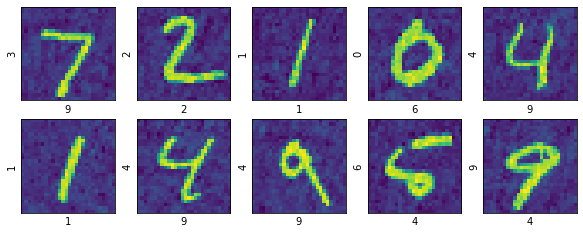

In [55]:


plt.figure(figsize=(10,10))
for i in range(10):
    img = tf.reshape(advs[i], shape=[28, 28])
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
    plt.ylabel(po[i])
    plt.xlabel(pa[i])
plt.show()